In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
print('tensorflow version: {}'.format(tf.__version__))
print('tensorflow probability version: {}'.format(tfp.__version__))

tensorflow version: 2.0.0-rc0
tensorflow probability version: 0.8.0-rc0


p(x_1, x_2) = N(x_1 | \mu = 1 / {4 {x_2} ^2}, \sigma = 1) \dot N(x_2 | \mu = 0, \sigma =4)

In [2]:
batch_size = 512
x2_dist = tfd.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(batch_size)

x1_dist = tfd.Normal(
    loc=.25 * tf.square(x2_samples),
    scale = tf.ones(batch_size, dtype=tf.float32)
)
x1_samples = x1_dist.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)

(-10, 10)

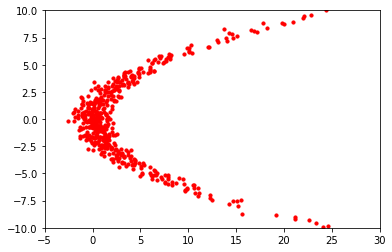

In [3]:
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=10, color='red')
plt.xlim([-5, 30])
plt.ylim([-10, 10])

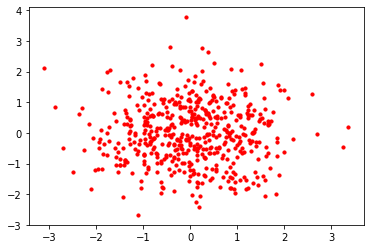

In [4]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], dtype=tf.float32))
base_samples =base_dist.sample(batch_size)
plt.scatter(base_samples[:, 0], base_samples[:, 1], s=10, color='red')

x_samples を base_samples へ変換するため、Normalizing Flow を用います。

In [5]:
class LeakyReLU(tfb.Bijector):
    def __init__(self, alpha=0.5, validate_args=False, name='leaky_relu'):
        super(LeakyReLU, self).__init__(
            forward_min_event_ndims=1,
            validate_args=validate_args, name=name
        )
        self.alpha = alpha
    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)

    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1. / self.alpha * y)

    def _inverse_log_det_jacobian(self, y):
        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1. / self.alpha * I)
        log_abs_det_J_inv = tf.math.log(tf.abs(J_inv))
        # ref https://stackoverflow.com/questions/50672019/tensorflow-bijector-construction
        event_ndims=1 # for vector
        return tf.reduce_sum(log_abs_det_J_inv, axis=event_ndims)

In [6]:
d, r = 2, 2
flow_layers = []
num_layers = 6
alpha = tf.Variable(0, dtype=tf.float32, name='alpha{}'.format(0))
for i in range(num_layers):
    V = tf.Variable(tf.random.normal([d]),  name='V{}'.format(i))
    shift = tf.Variable(tf.random.normal([d]), name='shift{}'.format(i))
    flow_layers.append(tfb.AffineScalar(
        scale=V,
        shift=shift
    ))
    alpha = alpha + 0.01
    flow_layers.append(LeakyReLU(alpha=alpha))
flow = tfb.Chain(
    list(reversed(flow_layers)),
    name='flow_chain'
)

In [7]:
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow
)
dist.vars= dist.trainable_variables

x[0] : base distribution
...
x[6] : target distribution

In [8]:
x = base_dist.sample(512)
samples = [x]
names=[base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

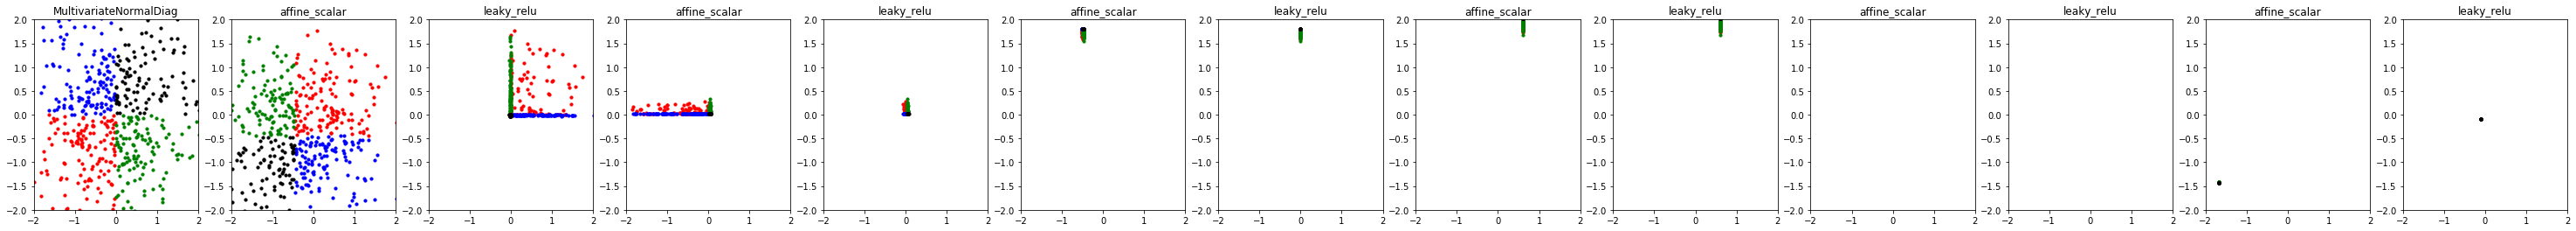

In [9]:
f, arr = plt.subplots(1, len(samples), figsize=(4 * len(samples), 4))
X0 = np.array(samples[0])
for i in range(len(samples)):
    X1 = np.array(samples[i])
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-2, 2])
    arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

Optimize Flow

In [10]:
dist.trainable_variables

(<tf.Variable 'V5:0' shape=(2,) dtype=float32, numpy=array([-1.2061176 , -0.19675437], dtype=float32)>,
 <tf.Variable 'shift5:0' shape=(2,) dtype=float32, numpy=array([-1.1099123 , -0.91019183], dtype=float32)>,
 <tf.Variable 'V4:0' shape=(2,) dtype=float32, numpy=array([-0.06625614,  0.4608949 ], dtype=float32)>,
 <tf.Variable 'shift4:0' shape=(2,) dtype=float32, numpy=array([0.5018359, 1.7630209], dtype=float32)>,
 <tf.Variable 'V3:0' shape=(2,) dtype=float32, numpy=array([-1.9347249,  1.3786117], dtype=float32)>,
 <tf.Variable 'shift3:0' shape=(2,) dtype=float32, numpy=array([ 0.5757677 , -0.45363474], dtype=float32)>,
 <tf.Variable 'V2:0' shape=(2,) dtype=float32, numpy=array([ 0.40694138, -0.84428847], dtype=float32)>,
 <tf.Variable 'shift2:0' shape=(2,) dtype=float32, numpy=array([-0.4959165,  1.8193494], dtype=float32)>,
 <tf.Variable 'V1:0' shape=(2,) dtype=float32, numpy=array([-1.1943407 ,  0.14194523], dtype=float32)>,
 <tf.Variable 'shift1:0' shape=(2,) dtype=float32, numpy

In [11]:
optimizer  = tf.optimizers.Adam(1e-3)
NUM_STEPS=int(5e4)
global_step = []
losses = []
for i in range(NUM_STEPS):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(x_samples))
        grads = tape.gradient(loss, dist.trainable_variables)
    losses.append(loss)
    global_step.append(i)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    if i % 100 == 0:
        print(loss)

tf.Tensor(172606970000000.0, shape=(), dtype=float32)
tf.Tensor(26096890000000.0, shape=(), dtype=float32)
tf.Tensor(13006038000000.0, shape=(), dtype=float32)
tf.Tensor(8307806300000.0, shape=(), dtype=float32)
tf.Tensor(5944016000000.0, shape=(), dtype=float32)
tf.Tensor(4542142300000.0, shape=(), dtype=float32)
tf.Tensor(3623824700000.0, shape=(), dtype=float32)
tf.Tensor(2980565700000.0, shape=(), dtype=float32)
tf.Tensor(2507659800000.0, shape=(), dtype=float32)
tf.Tensor(2147039000000.0, shape=(), dtype=float32)
tf.Tensor(1864046000000.0, shape=(), dtype=float32)
tf.Tensor(1636780200000.0, shape=(), dtype=float32)
tf.Tensor(1450778700000.0, shape=(), dtype=float32)
tf.Tensor(1296110200000.0, shape=(), dtype=float32)
tf.Tensor(1165755800000.0, shape=(), dtype=float32)
tf.Tensor(1054612500000.0, shape=(), dtype=float32)
tf.Tensor(958891800000.0, shape=(), dtype=float32)
tf.Tensor(875723950000.0, shape=(), dtype=float32)
tf.Tensor(802899400000.0, shape=(), dtype=float32)
tf.Tensor(7

tf.Tensor(628692700.0, shape=(), dtype=float32)
tf.Tensor(599358100.0, shape=(), dtype=float32)
tf.Tensor(571353900.0, shape=(), dtype=float32)
tf.Tensor(544614300.0, shape=(), dtype=float32)
tf.Tensor(519085220.0, shape=(), dtype=float32)
tf.Tensor(494724700.0, shape=(), dtype=float32)
tf.Tensor(471469340.0, shape=(), dtype=float32)
tf.Tensor(449275900.0, shape=(), dtype=float32)
tf.Tensor(428095300.0, shape=(), dtype=float32)
tf.Tensor(407882080.0, shape=(), dtype=float32)
tf.Tensor(388597100.0, shape=(), dtype=float32)
tf.Tensor(370191780.0, shape=(), dtype=float32)
tf.Tensor(352629000.0, shape=(), dtype=float32)
tf.Tensor(335872400.0, shape=(), dtype=float32)
tf.Tensor(319888670.0, shape=(), dtype=float32)
tf.Tensor(304637900.0, shape=(), dtype=float32)
tf.Tensor(290093760.0, shape=(), dtype=float32)
tf.Tensor(276219650.0, shape=(), dtype=float32)
tf.Tensor(262986610.0, shape=(), dtype=float32)
tf.Tensor(250369020.0, shape=(), dtype=float32)
tf.Tensor(238336510.0, shape=(), dtype=f

tf.Tensor(35001.715, shape=(), dtype=float32)
tf.Tensor(33290.6, shape=(), dtype=float32)
tf.Tensor(31676.04, shape=(), dtype=float32)
tf.Tensor(30134.643, shape=(), dtype=float32)
tf.Tensor(28661.455, shape=(), dtype=float32)
tf.Tensor(27272.96, shape=(), dtype=float32)
tf.Tensor(25953.2, shape=(), dtype=float32)
tf.Tensor(24692.387, shape=(), dtype=float32)
tf.Tensor(23489.2, shape=(), dtype=float32)
tf.Tensor(22343.25, shape=(), dtype=float32)
tf.Tensor(21237.805, shape=(), dtype=float32)
tf.Tensor(20181.908, shape=(), dtype=float32)
tf.Tensor(19172.54, shape=(), dtype=float32)
tf.Tensor(18212.43, shape=(), dtype=float32)
tf.Tensor(17292.639, shape=(), dtype=float32)
tf.Tensor(16416.828, shape=(), dtype=float32)
tf.Tensor(15574.324, shape=(), dtype=float32)
tf.Tensor(14765.1875, shape=(), dtype=float32)
tf.Tensor(13999.548, shape=(), dtype=float32)
tf.Tensor(13268.618, shape=(), dtype=float32)
tf.Tensor(12579.734, shape=(), dtype=float32)
tf.Tensor(11920.244, shape=(), dtype=float32

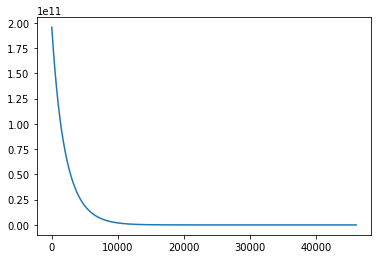

In [15]:
start=4000
plt.plot(losses[start:])

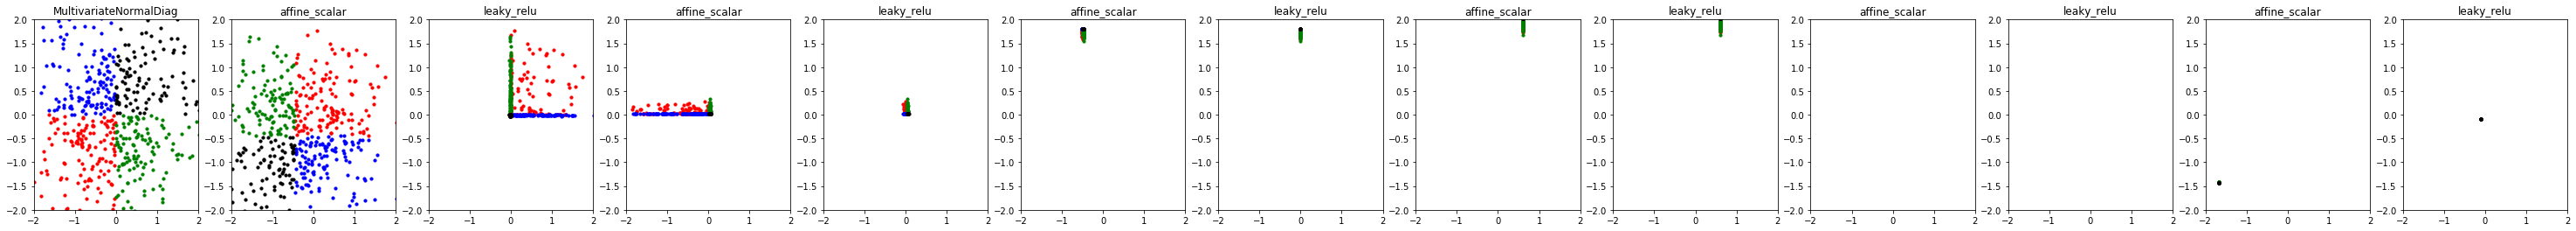

In [26]:
f, arr = plt.subplots(1, len(samples), figsize=(4 * (len(samples)), 4))
X0 = np.array(samples[0])
for i in range(len(samples)):
    X1 = np.array(samples[i])
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-2, 2])
    arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])
    plt.savefig('toy2d_flow.png', dpi=300)

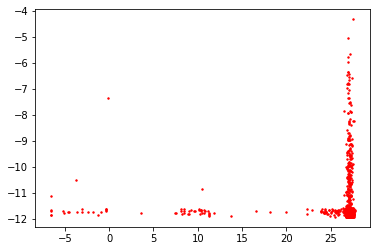

In [27]:
X1 = dist.sample(4000)
plt.scatter(X1[:, 0], X1[:, 1], color='red', s=2)
arr[i].set_xlim([-2.5, 2.5])
arr[i].set_ylim([-.5, .5])
plt.savefig('toy2d_out.png', dpi=300)